In [1]:
# # Раскомментировать, если не установлены 
# !pip install yfinance
# !pip install copulae
!pip install arch
# # # https://copulae.readthedocs.io/en/latest/getting-started.html

In [90]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from datetime import datetime

import yfinance as yf
from arch import arch_model 

plt.style.use("bmh")
%config InlineBackend.figure_formats=["png"]

###  1. Скачиваем котировки компаний Яндекс, CISCO, IBM, Apple, Oracle

In [91]:
data = yf.download("YNDX CSCO IBM AAPL ORCL", start="2016-01-01", end="2021-01-01", group_by="ticker")
data.head()

[*********************100%***********************]  5 of 5 completed


YNDX                                               ORCL  \
             Open   High    Low  Close Adj Close   Volume       Open   
Date                                                                   
2015-12-31  15.43  15.81  15.32  15.72     15.72  1102600  36.840000   
2016-01-04  15.25  15.29  14.51  15.22     15.22  3641800  36.009998   
2016-01-05  15.16  15.54  15.13  15.41     15.41  2422300  35.860001   
2016-01-06  15.04  15.06  14.69  14.97     14.97  4089500  35.500000   
2016-01-07  14.63  15.03  13.64  13.96     13.96  3417600  35.250000   

                                             ...         IBM              \
                 High        Low      Close  ...         Low       Close   
Date                                         ...                           
2015-12-31  36.950001  36.430000  36.529999  ...  137.570007  137.619995   
2016-01-04  36.009998  35.360001  35.750000  ...  134.240005  135.949997   
2016-01-05  36.119999  35.490002  35.639999  ...  134.850006  135.850006   
2016-01-06  36.139999  35.360001  35.820000  ...  133.619995  135.169998   
2016-01-07  35.680000  34.880001  35.040001  ...  132.429993  132.860001   

                                      AAPL                                   \
             Adj Close   Volume       Open       High        Low      Close   
Date                                                                          
2015-12-31  109.242401  3462100  26.752501  26.757500  26.205000  26.315001   
2016-01-04  107.916756  5229400  25.652500  26.342501  25.500000  26.337500   
2016-01-05  107.837402  3924800  26.437500  26.462500  25.602501  25.677500   
2016-01-06  107.297600  4310900  25.139999  25.592501  24.967501  25.174999   
2016-01-07  105.463943  7025800  24.670000  25.032499  24.107500  24.112499   

                                  
            Adj Close     Volume  
Date                              
2015-12-31  24.343718  163649200  
2016-01-04  24.364536  270597600  
2016-01-05  23.753977  223164000  
2016-01-06  23.289116  273829600  
2016-01-07  22.306208  324377600  

[5 rows x 30 columns]

In [92]:
prices = []

for ticker in data.columns.levels[0]:

    temp = data[ticker]['Close']
    temp.name = ticker
    prices.append(temp)

prices = pd.concat(prices, axis=1)

prices.head()

YNDX       ORCL       CSCO         IBM       AAPL
Date                                                          
2015-12-31  15.72  36.529999  27.160000  137.619995  26.315001
2016-01-04  15.22  35.750000  26.410000  135.949997  26.337500
2016-01-05  15.41  35.639999  26.290001  135.850006  25.677500
2016-01-06  14.97  35.820000  26.010000  135.169998  25.174999
2016-01-07  13.96  35.040001  25.410000  132.860001  24.112499

###  Строим график цен и смотрим на него

Text(0.5, 1.0, 'Stock price')

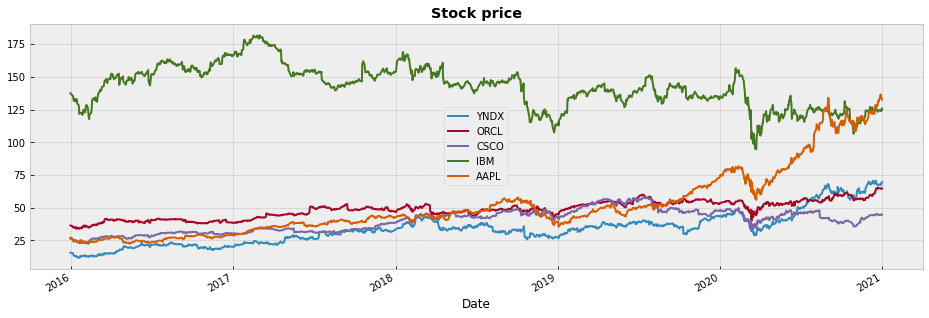

In [93]:
prices.plot(figsize=(16, 5))
plt.title("Stock price", weight="bold")

###  Теперь посмотрим на графики доходностей

In [94]:
returns = 100*prices.pct_change().dropna()

returns.head()

YNDX      ORCL      CSCO       IBM      AAPL
Date                                                        
2016-01-04 -3.180662 -2.135228 -2.761414 -1.213485  0.085499
2016-01-05  1.248355 -0.307694 -0.454369 -0.073550 -2.505932
2016-01-06 -2.855286  0.505051 -1.065046 -0.500558 -1.956968
2016-01-07 -6.746828 -2.177551 -2.306807 -1.708957 -4.220457
2016-01-08 -3.868195 -1.113012 -2.479336 -0.925783  0.528774

Text(0.5, 1.0, 'Daily returns')

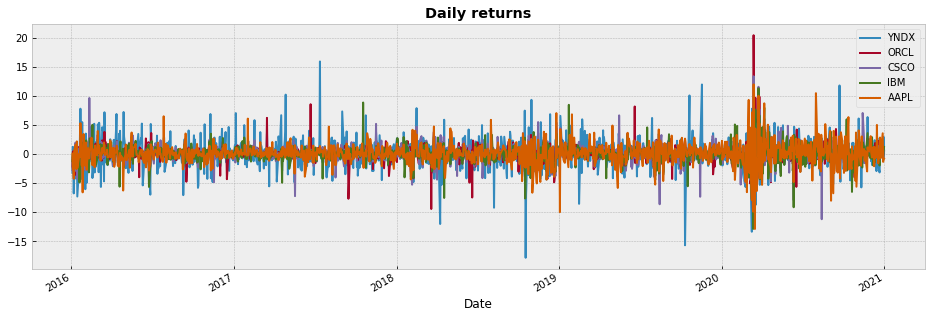

In [95]:
returns.plot(figsize=(16, 5))
plt.title("Daily returns", weight="bold")

Text(0.5, 1.0, 'Daily returns')

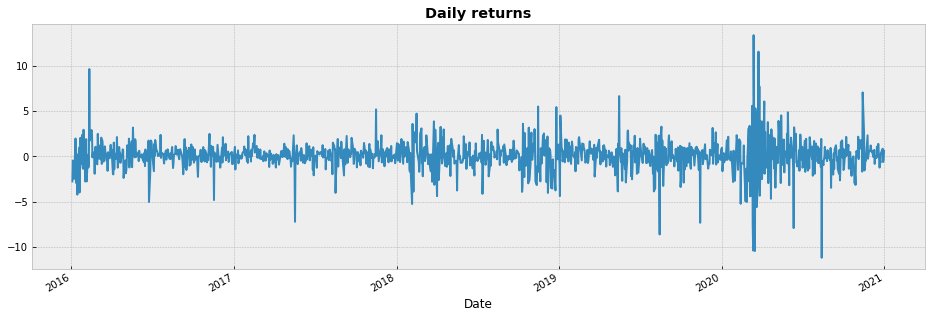

In [97]:
ret = returns['CSCO']

ret.plot(figsize=(16, 5))
plt.title("Daily returns", weight="bold")

In [98]:
def calculate_var_HS(returns, alpha):
    
    return returns.quantile(alpha)


def calculate_var_gennorm(returns, alpha):
    beta, loc, scale = scipy.stats.gennorm.fit(returns)
    
    return scipy.stats.gennorm.ppf(alpha, beta, loc, scale)


def calculate_var_garch(returns, alpha):
    
    scaling_const = 1.0 #10 / ret_estimation.std()

    dist = 'skewstudent'
    am = arch_model(scaling_const * returns,
                    mean='Constant', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Harch', p=2, o=1, q=2, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off')

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    if dist == 'Normal':
        q = am.distribution.ppf(alpha)
    elif dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])

    return_garch_forecast = cond_mean / scaling_const
    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return return_garch_forecast, VaR_garch_forecast

In [99]:
ret = returns['YNDX']

returns.columns

Index(['YNDX', 'ORCL', 'CSCO', 'IBM', 'AAPL'], dtype='object')

In [100]:
alpha = 0.01

T = len(ret)
T_start = 100
estimation_window = 250
testing_window = T - estimation_window

VaR_curve_HS = []
VaR_curve_gennorm = []
VaR_curve_garch = []
forecast_garch = []

for t in range(estimation_window+T_start, T):
    
    current_estimation_sample = ret[t-estimation_window:t]

    VaR_curve_HS.append(calculate_var_HS(current_estimation_sample, alpha))
    VaR_curve_gennorm.append(calculate_var_gennorm(current_estimation_sample, alpha))
    
    return_garch_forecast, VaR_garch_forecast = calculate_var_garch(current_estimation_sample, alpha)
    forecast_garch.append(return_garch_forecast)
    VaR_curve_garch.append(VaR_garch_forecast)
    
VaR_curve_HS = pd.Series(VaR_curve_HS, index=ret[estimation_window+T_start:].index)
VaR_curve_gennorm = pd.Series(VaR_curve_gennorm, index=ret[estimation_window+T_start:].index)
VaR_curve_garch = pd.Series(VaR_curve_garch, index=ret[estimation_window+T_start:].index)
forecast_garch = pd.Series(forecast_garch, index=ret[estimation_window+T_start:].index)

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

KeyboardInterrupt: 

In [ ]:
fig = plt.figure()
fig.set_size_inches(18,6)
ret[estimation_window+T_start:].plot()
forecast_garch.plot()
VaR_curve_HS.plot()
VaR_curve_gennorm.plot()
VaR_curve_garch.plot()

plt.title("Stock returns and VaR curve", weight="bold")

plt.legend(['Historical Returns',
            'ARMA-GARCH forecast for Returns',
            'VaR via Historical Simulation',
            'VaR via Generalized Normal disctribution',
           'VaR via GARCH'])

###  Для выбора подходящей модели будем использовать тест Купика, который сравнивает модельную и реальную частоту пробоев

In [101]:
def kupiec_test(VaR_curve, actual_returns, pp=0.1):
    
    T = len(actual_returns)
    K = (actual_returns < VaR_curve).sum()
    alpha_0 = K / T
    
    S = -2*np.log((1-alpha)**(T-K) * alpha**K) + 2*np.log((1-alpha_0)**(T-K) * alpha_0**K)
    p_value = 1 - scipy.stats.chi2.cdf(S, df=1)
        
    if np.isnan(p_value):
        p_value = 0.
        
    print('Количество наблюдений:', T)
    print('Желаемый уровень пробитий: {:.1f}%'.format(alpha*100))
    print('Уровень пробитий в модели: {:.2f}%'.format(alpha_0*100))
        
    print('\np-value теста: {:.3f}'.format(p_value))
    if p_value > pp:
        print("""\nПри уровне значимости {:.0f}% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ""".format(pp*100))
    else:
        print("""\nПри уровне значимости {:.1f}% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается""".format(pp*100))

In [15]:
kupiec_test(VaR_curve_garch, ret[estimation_window+T_start:])

Количество наблюдений: 751
Желаемый уровень пробитий: 1.0%
Уровень пробитий в модели: 0.93%

p-value теста: 0.850

При уровне значимости 10% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ


Text(0.5, 1.0, 'ORCL vs CSCO daily returns')

<Figure size 432x432 with 0 Axes>

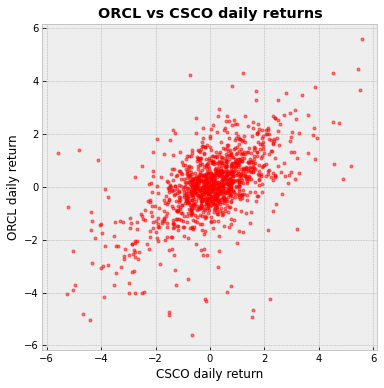

In [103]:
idx = (returns['CSCO'] > -6) & (returns['CSCO'] < 6)
idx = idx & (returns['ORCL'] > -6) & (returns['ORCL'] < 6)

x = returns.loc[idx, 'CSCO']
y = returns.loc[idx, 'ORCL']

fig = plt.figure()
fig.set_size_inches(6,6)

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.5)

plt.xlabel("CSCO daily return")
plt.ylabel("ORCL daily return")
plt.title("ORCL vs CSCO daily returns", weight="bold")

###  Мы можем смоделировать частные распределения с помощью уже известных нам распределений, например Стьюдента

In [104]:
n_samples = 10 ** 5

return_simulations = {}

# для каждой акции оцениваем одномерное распределение, а потом сэмплируем из него новые псевдо-наблюдения
for col in returns.columns:
    t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
    return_simulations[col] = scipy.stats.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=n_samples, random_state=42)
    
return_simulations = pd.DataFrame(return_simulations)

In [105]:
return_simulations.shape

(100000, 5)

In [106]:
returns.head()

YNDX      ORCL      CSCO       IBM      AAPL
Date                                                        
2016-01-04 -3.180662 -2.135228 -2.761414 -1.213485  0.085499
2016-01-05  1.248355 -0.307694 -0.454369 -0.073550 -2.505932
2016-01-06 -2.855286  0.505051 -1.065046 -0.500558 -1.956968
2016-01-07 -6.746828 -2.177551 -2.306807 -1.708957 -4.220457
2016-01-08 -3.868195 -1.113012 -2.479336 -0.925783  0.528774

In [107]:
np.cov(returns.values, rowvar=False)

array([[6.81533841, 1.52819307, 1.73103879, 1.43754347, 2.14238042],
       [1.52819307, 2.67155166, 1.71919595, 1.50595967, 1.62828815],
       [1.73103879, 1.71919595, 2.99169239, 1.70682541, 1.88942242],
       [1.43754347, 1.50595967, 1.70682541, 2.66387866, 1.45291198],
       [2.14238042, 1.62828815, 1.88942242, 1.45291198, 3.61669758]])

In [108]:
np.cov(return_simulations.values, rowvar=False)

array([[ 6.99921561e+00,  1.14920943e-02,  9.49343273e-03,
         3.57657636e-02,  6.03892217e-02],
       [ 1.14920943e-02,  4.15138555e+00, -2.74605144e-04,
         5.88423819e-03, -1.00211013e-02],
       [ 9.49343273e-03, -2.74605144e-04,  4.13389276e+00,
         1.35307572e-01,  4.80441863e-02],
       [ 3.57657636e-02,  5.88423819e-03,  1.35307572e-01,
         4.19647122e+00,  6.15805533e-02],
       [ 6.03892217e-02, -1.00211013e-02,  4.80441863e-02,
         6.15805533e-02,  5.23261582e+00]])

In [109]:
return_simulations.head()

YNDX      ORCL      CSCO       IBM      AAPL
0  1.202859  0.607775  0.691895  0.588228  0.828448
1 -1.778677 -0.773809 -0.913869 -0.904233 -1.034024
2  2.509925  1.122118  1.303550  1.146741  1.550052
3 -1.287793 -0.642995 -0.745803 -0.759539 -0.825355
4  1.613460  1.507309  1.553447  1.518273  1.693273

Text(0.5, 1.0, 'ORCL vs CSCO daily returns')

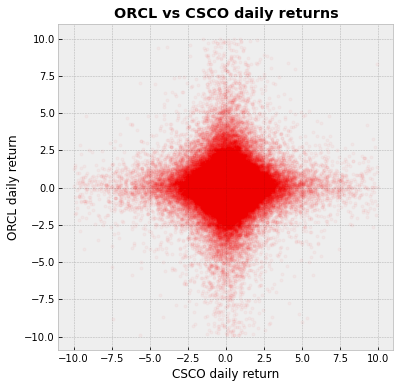

In [111]:
idx = (return_simulations['CSCO'] > -10) & (return_simulations['CSCO'] < 10)
idx = idx & (return_simulations['ORCL'] > -10) & (return_simulations['ORCL'] < 10)

x = return_simulations.loc[idx, 'CSCO']
y = return_simulations.loc[idx, 'ORCL']

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("CSCO daily return")
plt.ylabel("ORCL daily return")
plt.title("ORCL vs CSCO daily returns", weight="bold")

In [24]:
n_samples = 10 ** 5

# оцениваем параметры нормального распределения распределение
mean = np.mean(returns.values, axis=0)
cov = np.cov(returns.values, rowvar=False)

# а потом сэмплируем из него новые псевдо-наблюдения
return_simulations = scipy.stats.multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples, random_state=42)

return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

Text(0.5, 1.0, 'ORCL vs CSCO daily returns')

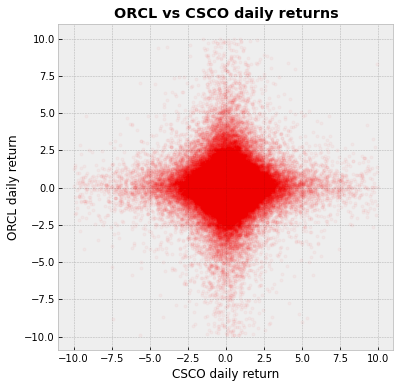

In [112]:
idx = (return_simulations['CSCO'] > -10) & (return_simulations['CSCO'] < 10)
idx = idx & (return_simulations['ORCL'] > -10) & (return_simulations['ORCL'] < 10)

x = return_simulations.loc[idx, 'CSCO']
y = return_simulations.loc[idx, 'ORCL']

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("CSCO daily return")
plt.ylabel("ORCL daily return")
plt.title("ORCL vs CSCO daily returns", weight="bold")

In [113]:
w = np.ones(shape=(returns.shape[1],)) / 5
w

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [114]:
alpha = 0.05

In [115]:
# умножаем матрицу псевдо-наблюдений на вектор весов и получаем псевдо-наблюдения доходностей портфеля

portfolio_real_returns = np.dot(returns.values, w)
portfolio_simulated_returns = np.dot(return_simulations.values, w)

print(np.quantile(portfolio_real_returns, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-2.011471633271547
-1.3031183019199999


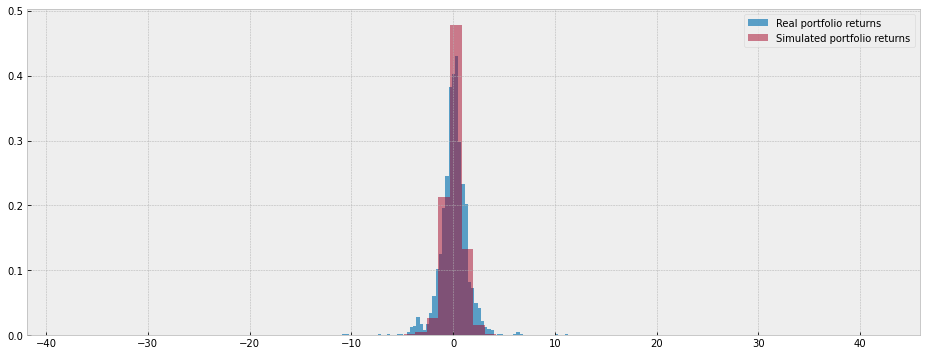

In [116]:
fig = plt.figure()
fig.set_size_inches(16,6)

plt.hist(portfolio_real_returns, bins=70, density=True, alpha=0.8, label='Real portfolio returns')
plt.hist(portfolio_simulated_returns, bins=70, density=True, alpha=0.5, label='Simulated portfolio returns')
plt.legend(loc='upper right')

In [117]:
from copulae import NormalCopula, GaussianCopula, StudentCopula

In [118]:
cdfs = returns.copy()
distribution_params = {}

for col in cdfs.columns:
    t_df, t_mean, t_sigma = scipy.stats.t.fit(cdfs[col])
    distribution_params[col] = (t_df, t_mean, t_sigma)
    cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

In [119]:
distribution_params

{'YNDX': (3.643893030453331, 0.161822115659778, 1.7881258808468892),
 'ORCL': (2.3096024191670703, 0.10587347158626859, 0.788052960756608),
 'CSCO': (2.4306284608948774, 0.1116369495879884, 0.9228248004388888),
 'IBM': (2.3357947597410114, 0.04669445789634957, 0.8527537686178204),
 'AAPL': (2.5303026344596873, 0.15810489310334794, 1.0762545711812446)}

###  Вот так выглядят доходности

Text(0.5, 1.0, 'ORCL vs CSCO daily returns')

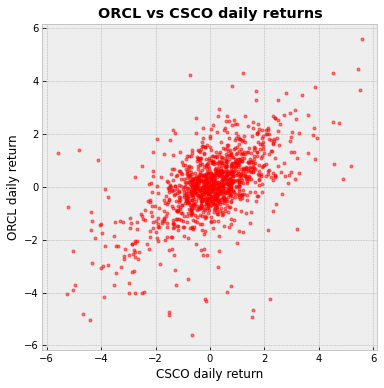

In [121]:
idx = (returns['CSCO'] > -6) & (returns['CSCO'] < 6)
idx = idx & (returns['ORCL'] > -6) & (returns['ORCL'] < 6)

x = returns.loc[idx, 'CSCO']
y = returns.loc[idx, 'ORCL']

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.5)
plt.xlabel("CSCO daily return")
plt.ylabel("ORCL daily return")
plt.title("ORCL vs CSCO daily returns", weight="bold")

Text(0, 0.5, 'ORCL daily return')

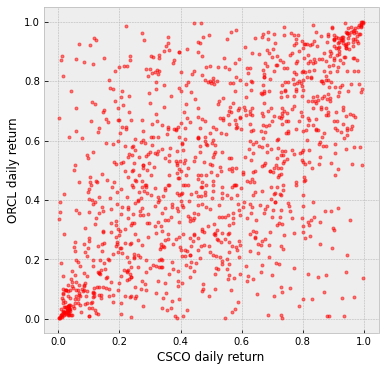

In [123]:
x = cdfs['CSCO']
y = cdfs['ORCL']

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.5)
plt.xlabel("CSCO daily return")
plt.ylabel("ORCL daily return")

In [124]:
returns.head()

YNDX      ORCL      CSCO       IBM      AAPL
Date                                                        
2016-01-04 -3.180662 -2.135228 -2.761414 -1.213485  0.085499
2016-01-05  1.248355 -0.307694 -0.454369 -0.073550 -2.505932
2016-01-06 -2.855286  0.505051 -1.065046 -0.500558 -1.956968
2016-01-07 -6.746828 -2.177551 -2.306807 -1.708957 -4.220457
2016-01-08 -3.868195 -1.113012 -2.479336 -0.925783  0.528774

In [125]:
cdfs.head()

YNDX      ORCL      CSCO       IBM      AAPL
Date                                                        
2016-01-04  0.070948  0.044381  0.034852  0.130075  0.475590
2016-01-05  0.710379  0.322905  0.296092  0.449554  0.052688
2016-01-06  0.086880  0.671621  0.155265  0.289173  0.080463
2016-01-07  0.010763  0.042820  0.049099  0.078549  0.018376
2016-01-08  0.046912  0.122748  0.042914  0.178748  0.621437

###  Оценим Нормальную копулу и посмотрим на ее описание

In [126]:
cop = NormalCopula(dim=5)
cop.fit(cdfs)

In [127]:
cop.summary()

Gaussian Copula Summary
================================================================================
Gaussian Copula with 5 dimensions


Parameters
--------------------------------------------------------------------------------
 Correlation Matrix 
 1.000000  0.405343  0.410821  0.336442  0.440335
 0.405343  1.000000  0.582428  0.563658  0.485430
 0.410821  0.582428  1.000000  0.594399  0.544766
 0.336442  0.563658  0.594399  1.000000  0.418235
 0.440335  0.485430  0.544766  0.418235  1.000000



                                  Fit Summary                                   
================================================================================
Log. Likelihood      : -1045.6612047559825
Variance Estimate    : Not Implemented Yet
Method               : Maximum pseudo-likelihood
Data Points          : 1259

Optimization Setup
--------------------------------------------------------------------------------
	bounds         : [(-1.000001, 1.000001), (-1.000001, 1.000001), (-1.000001, 1.000001), (-1.000001, 1.000001), (-1.000001, 1.000001), (-1.000001, 1.000001), (-1.000001, 1.000001), (-1.000001, 1.000001), (-1.000001, 1.000001), (-1.000001, 1.000001)]
	options        : {'maxiter': 20000, 'ftol': 1e-06, 'iprint': 1, 'disp': False, 'eps': 1.5e-08}
	method         : SLSQP

Results
--------------------------------------------------------------------------------
	x              : [0.40534277 0.41082073 0.33644186 0.44033545 0.58242792 0.56365789
 0.48542969 0.5943988  0.54476574 0.41823508]
	fun            : -1045.6612047559825
	jac            : [-0.01309672  0.00607846  0.01045919 -0.01011055 -0.01347568  0.00436557
  0.01114131 -0.00433526  0.0094739  -0.01058046]
	nit            : 17
	nfev           : 212
	njev           : 17
	status         : 0
	message        : Optimization terminated successfully
	success        : True

###  Теперь мы можем сэмплировать частные квантили с помощью оцененной копулы, и можем построить их распределение

In [128]:
n_samples = 10 ** 5

copula_simulations = cop.random(n_samples, seed=42)

copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)

Text(0.5, 1.0, 'ORCL vs CSCO daily returns')

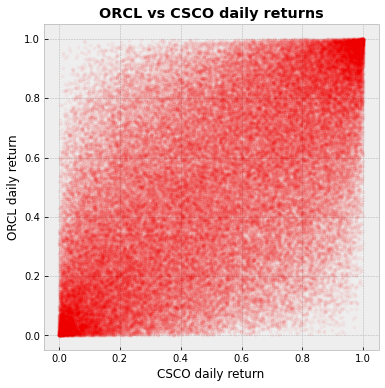

In [129]:
x = copula_simulations['CSCO']
y = copula_simulations['ORCL']

fig = plt.figure()
fig.set_size_inches(6,6)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("CSCO daily return")
plt.ylabel("ORCL daily return")
plt.title("ORCL vs CSCO daily returns", weight="bold")

###  Выглядит супер! Правда непонятно -- давайте вернемся от квантилей к доходностям с помощью inverse CDF и посмотрим на распределение сэмплов

In [41]:
return_simulations = copula_simulations.copy()

for col in cdfs.columns:
    t_df, t_mean, t_sigma = distribution_params[col]
    return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)

Text(0.5, 1.0, 'ORCL vs CSCO daily returns')

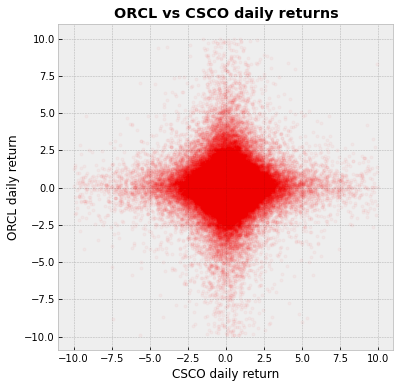

In [130]:
idx = (return_simulations['CSCO'] > -10) & (return_simulations['CSCO'] < 10)
idx = idx & (return_simulations['ORCL'] > -10) & (return_simulations['ORCL'] < 10)

x = return_simulations.loc[idx, 'CSCO']
y = return_simulations.loc[idx, 'ORCL']

fig = plt.figure()
fig.set_size_inches(6,6)

# fft_axes = fig.add_subplot(212)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("CSCO daily return")
plt.ylabel("ORCL daily return")
plt.title("ORCL vs CSCO daily returns", weight="bold")

In [131]:
portfolio_real_returns = np.dot(returns.values, w)
portfolio_simulated_returns = np.dot(return_simulations.values, w)

print(np.quantile(portfolio_real_returns, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-2.011471633271547
-1.3031183019199999


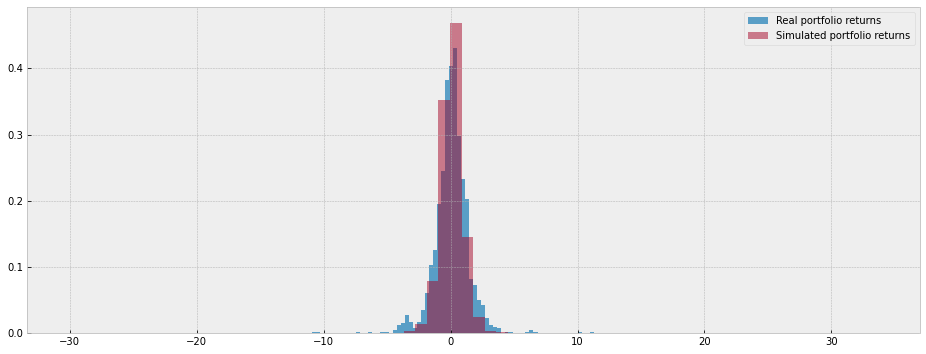

In [132]:
fig = plt.figure()
fig.set_size_inches(16,6)

plt.hist(portfolio_real_returns, bins=70, density=True, alpha=0.8, label='Real portfolio returns')
plt.hist(portfolio_simulated_returns[idx], bins=70, density=True, alpha=0.5, label='Simulated portfolio returns')
plt.legend(loc='upper right')

In [133]:
from copulae import ClaytonCopula, FrankCopula, GumbelCopula

In [134]:
univariate_dist = 'gennorm' # gennorm
cop = ClaytonCopula(dim=cdfs.shape[1])
n_samples = 10 ** 5

cdfs = returns.copy()
distribution_params = {}

for col in cdfs.columns:
    if univariate_dist == 't':
        t_df, t_mean, t_sigma = scipy.stats.t.fit(cdfs[col])
        distribution_params[col] = (t_df, t_mean, t_sigma)
        cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)
    else:
        beta, loc, scale = scipy.stats.gennorm.fit(cdfs[col])
        distribution_params[col] = (beta, loc, scale)
        cdfs[col] = scipy.stats.gennorm.cdf(cdfs[col], beta, loc, scale)

cop.fit(cdfs)

copula_simulations = cop.random(n_samples, seed=42)
copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)

return_simulations = copula_simulations.copy()

for col in cdfs.columns:
    if univariate_dist == 't':
        t_df, t_mean, t_sigma = distribution_params[col]
        return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)
    else:
        beta, loc, scale = distribution_params[col]
        return_simulations[col] = scipy.stats.gennorm.ppf(copula_simulations[col], beta, loc, scale)

In [135]:
portfolio_real_returns = np.dot(returns.values, w)
portfolio_simulated_returns = np.dot(return_simulations.values, w)

print(np.quantile(portfolio_real_returns, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-2.011471633271547
-2.1486576337747287


Text(0.5, 1.0, 'ORCL vs CSCO daily returns')

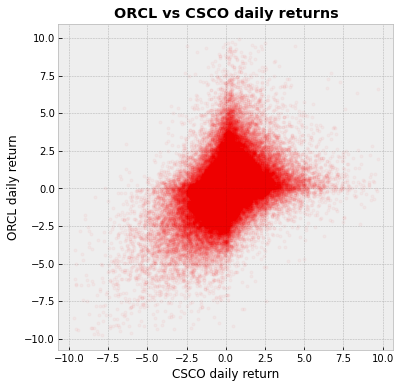

In [136]:
idx = (return_simulations['CSCO'] > -10) & (return_simulations['CSCO'] < 10)
idx = idx & (return_simulations['ORCL'] > -10) & (return_simulations['ORCL'] < 10)

x = return_simulations.loc[idx, 'ORCL']
y = return_simulations.loc[idx, 'CSCO']

fig = plt.figure()
fig.set_size_inches(6,6)

# fft_axes = fig.add_subplot(212)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("CSCO daily return")
plt.ylabel("ORCL daily return")
plt.title("ORCL vs CSCO daily returns", weight="bold")

In [137]:
from arch import arch_model 

In [138]:
ret.isna().sum()

0

### 2. Добавим в функции параметры lags (get_garch_residuals, make_copula_simulation):

In [139]:
ret = returns.dropna()
# dist = 'ged'

def get_garch_residuals(ret, dist, lags):

    scaling_const = 10.0 / ret.std()

    # объявляем GARCH модель
    am = arch_model(ret * scaling_const,
                    mean='Harx', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=2, o=1, q=2, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    # фитим модель на данных
    res = am.fit(update_freq=0, disp='off')


    # сохраняем ее распределение
    if dist == 'Normal':
        cdf = am.distribution.cdf(res.resid.dropna())
    elif dist == 't' or dist == 'ged':
        cdf = am.distribution.cdf(res.resid.dropna(), res.params[-1:])
    elif dist == 'skewstudent':
        cdf = am.distribution.cdf(res.resid, res.params[-2:])

        
    return cdf, am, res, scaling_const, lags


def make_garch_forecast(copula_simulation, dist, garch_object, garch_model, scaling_const, lags):
    
    # делаем прогноз среднего и дисперсии
    forecasts = garch_object.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # получаем из сэплов квантили сэмплы доходностей
    if dist == 'Normal':
        q = garch_model.distribution.ppf(copula_simulation)
    elif dist == 't' or dist == 'ged':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-1:])
    elif dist == 'skewstudent':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-2:])

    # и по формуле считаем ВаР
    return (cond_mean + np.sqrt(cond_var) * q) / scaling_const

In [140]:
def make_copula_simulation(returns, copula_func, n_samples, univariate_dist, lags, dist='skewstudent'):

    # объявляем копулу
    cop = copula_func(dim=returns.shape[1])
    cdfs = returns.copy()
    distribution_params = {}

    # моделируем частные распределения для каждой акции
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
            distribution_params[col] = (t_df, t_mean, t_sigma)
            cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = scipy.stats.gennorm.fit(returns[col])
            distribution_params[col] = (beta, loc, scale)
            cdfs[col] = scipy.stats.gennorm.cdf(cdfs[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            cdf, am, res, scaling_const, lags= get_garch_residuals(returns[col], dist, lags)
            distribution_params[col] = (am, res, lags)
            cdfs[col] = cdf


    # фитим копулу
    cop.fit(cdfs)

    # делаем сэмплирование квантилей из совместного распределения копулы
    copula_simulations = cop.random(n_samples, seed=42)
    copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)

    return_simulations = copula_simulations.copy()

    # трансформируем квантили в доходности с помощью частных функций распределений из первого шага
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = distribution_params[col]
            return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)

        elif univariate_dist == 'gennorm':
            beta, loc, scale = distribution_params[col]
            return_simulations[col] = scipy.stats.gennorm.ppf(copula_simulations[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            am, res, lags = distribution_params[col]
            return_simulations[col] = make_garch_forecast(copula_simulations[col], dist, res, am, scaling_const, lags)
            
    # возвращаем матрицу сэмплированных доходностей
    return return_simulations

###  Посмотрим, как можно использовать все эти замечательные функции

In [141]:
return_simulations = make_copula_simulation(returns, ClaytonCopula, n_samples=10**5, univariate_dist='garch', lags = 5)

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [142]:
alpha = 0.05

w = np.ones(shape=(returns.shape[1],)) / 5

portfolio_real_returns = np.dot(returns.values, w)
portfolio_simulated_returns = np.dot(return_simulations.values, w)

print(np.quantile(portfolio_real_returns, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-2.011471633271547
-1.5966714277450877


Text(0.5, 1.0, 'ORCL vs CSCO daily returns')

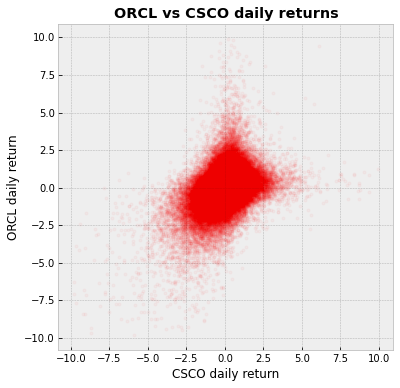

In [143]:
idx = (return_simulations['CSCO'] > -10) & (return_simulations['CSCO'] < 10)
idx = idx & (return_simulations['ORCL'] > -10) & (return_simulations['ORCL'] < 10)

x = return_simulations.loc[idx, 'CSCO']
y = return_simulations.loc[idx, 'ORCL']

fig = plt.figure()
fig.set_size_inches(6,6)

# fft_axes = fig.add_subplot(212)

plt.plot(x, y, "r.", alpha=0.03)
plt.xlabel("CSCO daily return")
plt.ylabel("ORCL daily return")
plt.title("ORCL vs CSCO daily returns", weight="bold")

###  И теперь перейдем к бэктесту -- напишем еще пару функций для моделирования совместного распределения доходностей

In [144]:
def make_dummy_student_simulations(returns, n_samples):
    
    return_simulations = {}

    for col in returns.columns:
        t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
        return_simulations[col] = scipy.stats.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=n_samples, random_state=42)

    return_simulations = pd.DataFrame(return_simulations)

    return return_simulations


def make_mult_normal_simulations(returns, n_samples):

    mean = np.mean(returns.values, axis=0)
    cov = np.cov(returns.values, rowvar=False)

    return_simulations = scipy.stats.multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples, random_state=42)

    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

    return return_simulations


###  И наконец-то перейдем к самому бэктесту!

In [147]:
alpha = 0.05

w = np.ones(shape=(returns.shape[1],)) / 5

# определяем параметры бэктеста
T = len(ret)
T_start = 100
estimation_window = 250
testing_window = T - estimation_window

VaR_curve_HS = []
VaR_curve_student = []
VaR_curve_multivariate_normal = []
VaR_curve_copula_t = []
VaR_curve_copula_garch = []

# в цикле проходимся по всем дням в выборке
for t in range(estimation_window+T_start, T):
    
    # фиксируем часть выборки
    current_estimation_sample = returns[t-estimation_window:t]
    
    # различными способами оцениваем ВаР и сохраняем значения
    protfolio = np.dot(current_estimation_sample.values, w)
    VaR_curve_HS.append(np.quantile(protfolio, alpha))
    
    student_simulation = make_dummy_student_simulations(current_estimation_sample, 10**4)
    VaR_curve_student.append(np.quantile(np.dot(student_simulation.values, w), alpha))
    
    multivariate_normal_simulation = make_mult_normal_simulations(current_estimation_sample, 10**4)
    VaR_curve_multivariate_normal.append(np.quantile(np.dot(multivariate_normal_simulation.values, w), alpha))
    
    copula_t_simulation = make_copula_simulation(current_estimation_sample, ClaytonCopula, n_samples=10**4, univariate_dist='t', lags=3)
    VaR_curve_copula_t.append(np.quantile(np.dot(copula_t_simulation.values, w), alpha))
    
    copula_garch_simulation = make_copula_simulation(current_estimation_sample, ClaytonCopula,
                                                     n_samples=10**4, univariate_dist='garch', lags = 3)
    VaR_curve_copula_garch.append(np.quantile(np.dot(copula_garch_simulation.values, w), alpha))
    
    
VaR_curve_HS = pd.Series(VaR_curve_HS, index=ret[estimation_window+T_start:].index)
VaR_curve_student = pd.Series(VaR_curve_student, index=ret[estimation_window+T_start:].index)
VaR_curve_multivariate_normal = pd.Series(VaR_curve_multivariate_normal, index=ret[estimation_window+T_start:].index)

VaR_curve_copula_t = pd.Series(VaR_curve_copula_t, index=ret[estimation_window+T_start:].index)
VaR_curve_copula_garch = pd.Series(VaR_curve_copula_garch, index=ret[estimation_window+T_start:].index)

portfolio = np.dot(returns[estimation_window+T_start:].values, w)
portfolio = pd.Series(portfolio, index=ret[estimation_window+T_start:].index)

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

In [148]:
from copulae import ClaytonCopula, FrankCopula, GumbelCopula, NormalCopula, StudentCopula, GaussianCopula

In [149]:
#Моделирование разными копулами

alpha = 0.05

w = np.ones(shape=(returns.shape[1],)) / 5

# определяем параметры бэктеста
T = len(ret)
T_start = 100
estimation_window = 250
testing_window = T - estimation_window


VaR_curve_copula_garch_Gumbel = []
VaR_curve_copula_garch_Normal =[]
VaR_curve_copula_garch_Gaussian =[]
VaR_curve_copula_garch_Student =[]
VaR_curve_copula_garch_Frank = []
for t in range(estimation_window+T_start, T):
    
    # фиксируем часть выборки
    current_estimation_sample = returns[t-estimation_window:t]
    
    copula_garch_simulation_Gumbel = make_copula_simulation(current_estimation_sample, GumbelCopula,
                                                     n_samples=10**4, univariate_dist='garch', lags = 3)
    VaR_curve_copula_garch_Gumbel.append(np.quantile(np.dot(copula_garch_simulation_Gumbel.values, w), alpha))

    copula_garch_simulation_Normal = make_copula_simulation(current_estimation_sample, NormalCopula,
                                                     n_samples=10**4, univariate_dist='garch', lags = 3)
    VaR_curve_copula_garch_Normal.append(np.quantile(np.dot(copula_garch_simulation_Normal.values, w), alpha))

VaR_curve_copula_garch_Gumbel = pd.Series(VaR_curve_copula_garch_Gumbel, index=ret[estimation_window+T_start:].index)
VaR_curve_copula_garch_Normal = pd.Series(VaR_curve_copula_garch_Normal, index=ret[estimation_window+T_start:].index)


C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

In [150]:
#Моделирование разными копулами

alpha = 0.05

w = np.ones(shape=(returns.shape[1],)) / 5

# определяем параметры бэктеста
T = len(ret)
T_start = 100
estimation_window = 250
testing_window = T - estimation_window


VaR_curve_copula_garch_Gumbel = []
VaR_curve_copula_garch_Normal =[]
VaR_curve_copula_garch_Gaussian =[]
VaR_curve_copula_garch_Student =[]
VaR_curve_copula_garch_Frank = []
for t in range(estimation_window+T_start, T):
    current_estimation_sample = returns[t-estimation_window:t]
    copula_garch_simulation_Gaussian = make_copula_simulation(current_estimation_sample, GaussianCopula,
                                                     n_samples=10**4, univariate_dist='garch', lags = 3)
    VaR_curve_copula_garch_Gaussian.append(np.quantile(np.dot(copula_garch_simulation_Gaussian.values, w), alpha))

    copula_garch_simulation_Student = make_copula_simulation(current_estimation_sample, StudentCopula,
                                                     n_samples=10**4, univariate_dist='garch', lags = 3)
    VaR_curve_copula_garch_Student.append(np.quantile(np.dot(copula_garch_simulation_Student.values, w), alpha))

    copula_garch_simulation_Frank = make_copula_simulation(current_estimation_sample, FrankCopula,
                                                     n_samples=10**4, univariate_dist='garch', lags = 3)
    VaR_curve_copula_garch_Frank.append(np.quantile(np.dot(copula_garch_simulation_Frank.values, w), alpha))
VaR_curve_copula_garch_Gaussian = pd.Series(VaR_curve_copula_garch_Gaussian, index=ret[estimation_window+T_start:].index)
VaR_curve_copula_garch_Student = pd.Series(VaR_curve_copula_garch_Student, index=ret[estimation_window+T_start:].index)
VaR_curve_copula_garch_Frank = pd.Series(VaR_curve_copula_garch_Frank, index=ret[estimation_window+T_start:].index)

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

###  Посмотрим на график доходностей и на VaR кривые

In [152]:
alpha = 0.05

w = np.ones(shape=(returns.shape[1],)) / 5

# определяем параметры бэктеста
T = len(ret)
T_start = 100
estimation_window = 250
testing_window = T - estimation_window


VaR_curve_copula_garch_Clayton = []
for t in range(estimation_window+T_start, T):
    copula_garch_simulation_Clayton = make_copula_simulation(current_estimation_sample, ClaytonCopula,
                                                     n_samples=10**4, univariate_dist='garch', lags = 3)
    VaR_curve_copula_garch_Clayton.append(np.quantile(np.dot(copula_garch_simulation_Clayton.values, w), alpha))
VaR_curve_copula_garch_Clayton = pd.Series(VaR_curve_copula_garch_Clayton, index=ret[estimation_window+T_start:].index)

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

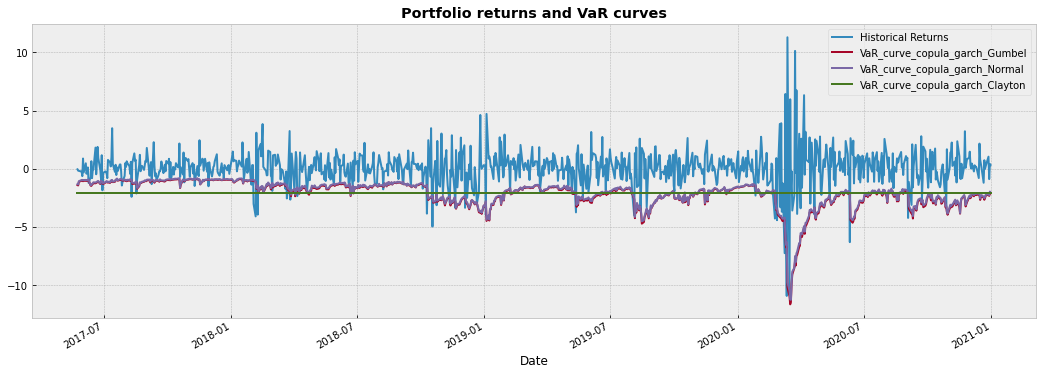

In [177]:
fig = plt.figure()
fig.set_size_inches(18,6)
portfolio.plot()
VaR_curve_HS.plot()
VaR_curve_student.plot()
VaR_curve_multivariate_normal.plot()
VaR_curve_copula_t.plot()
VaR_curve_copula_garch.plot()


#VaR_curve_copula_garch_Gumbel.plot()
#VaR_curve_copula_garch_Normal.plot()
VaR_curve_copula_garch_Gaussian.plot()
VaR_curve_copula_garch_Student.plot()
#VaR_curve_copula_garch_Frank.plot()
#VaR_curve_copula_garch_Clayton.plot()
plt.title("Portfolio returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
            'VaR via t-Student distribution',
            'VaR via Multivariate Normal disctribution',
            'VaR via Clayton Copula with t-Student marginal distribution',
            'VaR via Clayton Copula + GARCH with t-Student marginal distribution',
            #'VaR_curve_copula_garch_Gumbel',
            #'VaR_curve_copula_garch_Normal',
            'VaR_curve_copula_garch_Gaussian',
            'VaR_curve_copula_garch_Student',
            #'VaR_curve_copula_garch_Frank',
            #'VaR_curve_copula_garch_Clayton'
           ])

###  3. И проведем тесты Купика: добавлены Frank, Gaussian, Student copulas

In [163]:
kupiec_test(VaR_curve_HS, portfolio)

Количество наблюдений: 909
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 6.05%

p-value теста: 0.159

При уровне значимости 10% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ


In [164]:
kupiec_test(VaR_curve_student, portfolio)

Количество наблюдений: 909
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 11.44%

p-value теста: 0.000

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


In [165]:
kupiec_test(VaR_curve_multivariate_normal, portfolio)

Количество наблюдений: 909
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 5.61%

p-value теста: 0.407

При уровне значимости 10% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ


In [166]:
kupiec_test(VaR_curve_copula_t, portfolio)

Количество наблюдений: 909
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 6.60%

p-value теста: 0.034

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


In [167]:
kupiec_test(VaR_curve_copula_garch, portfolio)

Количество наблюдений: 909
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 6.16%

p-value теста: 0.121

При уровне значимости 10% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ


In [170]:
kupiec_test(VaR_curve_copula_garch_Gaussian, portfolio)

Количество наблюдений: 909
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 5.83%

p-value теста: 0.262

При уровне значимости 10% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, НЕ ОТВЕРГАЕТСЯ


In [171]:
kupiec_test(VaR_curve_copula_garch_Student, portfolio)

Количество наблюдений: 909
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 6.49%

p-value теста: 0.048

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


In [172]:
kupiec_test(VaR_curve_copula_garch_Frank, portfolio)

Количество наблюдений: 909
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 0.00%

p-value теста: 0.000

При уровне значимости 10.0% гипотеза гипотеза о
том, что эмпирическая и модельная частоты превышений фактическими
убытками границы VaR равны, отвергается


### Вывод: берём метод GaussianCopula+GARCH

#### Выбрали этот метод, так как у него наибольший p-value и наименьший процент пробоев

### 4. Функция для подбора весов: добавлен параметр Expected Success/Shortfall Ratio (es_to_sr):

In [178]:
from scipy.optimize import minimize

# объявляем целевую функцию, которую мы будем минимизировать (поэтому в нужных местах ставим минусы)
def calculate_objective_function(weights, returns_simulation, alpha, objective_type):
    
    portfolio_simulation = np.dot(returns_simulation.values, weights)
    
    if objective_type == 'return':
        return -np.mean(portfolio_simulation)
    
    elif objective_type == 'var':
        return -np.quantile(portfolio_simulation, alpha)
    
    elif objective_type == 'es_to_sr':
        return np.quantile(portfolio_simulation, 1-alpha)/np.quantile(portfolio_simulation, alpha)
    
    
def optimize(returns_simulation, alpha=0.1, objective_type='es_to_sr'):
        
    init_guess = np.ones(shape=(returns.shape[1],)) / returns.shape[1]
    
    # вот тут можно поставить другие ограничения, например от -1 до 1, чтобы появилась возможность шортить -- продавать какие-то акции
    bounds = ((0.0, 1.0),) * returns.shape[1]
    
    weights = minimize(calculate_objective_function, init_guess,
                       args=(returns_simulation,alpha,objective_type), method='SLSQP',
                       options={'disp': False},
                       constraints=({'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs)}),
                       bounds=bounds)
    
    return weights.x

###  5. И используем ее, чтобы сравнить поведение двух портфелей -- с константными весами, и с весами, которые максимизируют es to es оцененный с помощью GaussianCopula + Garch

In [180]:
alpha = 0.1

w = np.ones(shape=(returns.shape[1],)) / 5

T = len(ret)
T_start = 100
estimation_window = 250
testing_window = T - estimation_window

value = 100

value_const_weights = [value]
value_opt_weights_return = [value]
value_opt_weights_var = [value]
value_opt_weights_sharp = [value]
value_opt_weights_return_to_var = [value]
value_opt_weights_es_to_es = [value]

value_opt_weights_es_to_sr = [value]

# делаем почти то же самое, что и в бэктесте ВаР
for t in range(estimation_window+T_start, T):
    
    real_returns = returns.iloc[t].values / 100
    
    value_new = np.dot(1+real_returns, w) * value_const_weights[-1]
    value_const_weights.append(value_new)
    
    # фиксируем тренировочное окно и делаем сэмплы
    current_estimation_sample = returns[t-estimation_window:t]
    #copula_garch_simulation = make_copula_simulation(current_estimation_sample, ClaytonCopula, n_samples=10**4, univariate_dist='garch', lags = 3)
    
    #copula_garch_simulation_Student = make_copula_simulation(current_estimation_sample, StudentCopula,
                                                     #n_samples=10**4, univariate_dist='garch', lags = 5)
    
    
    # и различными способами оптимизируем веса в портфеле
    w_opt = optimize(copula_garch_simulation_Gaussian, objective_type='return')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_return[-1]
    value_opt_weights_return.append(value_new)
    
    #w_opt = optimize(copula_garch_simulation, objective_type='var')
    #value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_var[-1]
    #value_opt_weights_var.append(value_new)
    
#    w_opt = optimize(copula_garch_simulation, objective_type='sharp')
#    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_sharp[-1]
#    value_opt_weights_sharp.append(value_new)
    
#     w_opt = optimize(copula_garch_simulation, objective_type='return_to_var')
#     value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_return_to_var[-1]
#     value_opt_weights_return_to_var.append(value_new)
    
#     w_opt = optimize(copula_garch_simulation, objective_type='es_to_es')
#     value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_es_to_es[-1]
#     value_opt_weights_es_to_es.append(value_new)

    w_opt = optimize(copula_garch_simulation_Gaussian, objective_type='es_to_sr')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_es_to_sr[-1]
    value_opt_weights_es_to_sr.append(value_new)
    
    
    
value_const_weights.pop(0)
value_opt_weights_return.pop(0)
#value_opt_weights_var.pop(0)
#value_opt_weights_sharp.pop(0)
# value_opt_weights_return_to_var.pop(0)
# value_opt_weights_es_to_es.pop(0)
value_opt_weights_es_to_sr.pop(0)


value_const_weights = pd.Series(value_const_weights, index=ret[estimation_window+T_start:].index)
value_opt_weights_return = pd.Series(value_opt_weights_return, index=ret[estimation_window+T_start:].index)
#value_opt_weights_var = pd.Series(value_opt_weights_var, index=ret[estimation_window+T_start:].index)
#value_opt_weights_sharp = pd.Series(value_opt_weights_sharp, index=ret[estimation_window+T_start:].index)
# value_opt_weights_return_to_var = pd.Series(value_opt_weights_return_to_var, index=ret[estimation_window+T_start:].index)
# value_opt_weights_es_to_es = pd.Series(value_opt_weights_es_to_es, index=ret[estimation_window+T_start:].index)
value_opt_weights_es_to_sr = pd.Series(value_opt_weights_es_to_sr, index=ret[estimation_window+T_start:].index)

###  Посмотрим на график изменения стоимости нашего портфеля

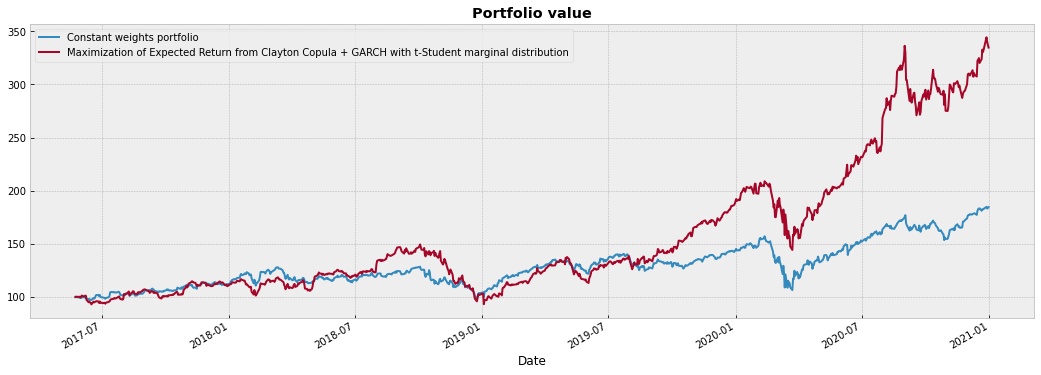

In [181]:
fig = plt.figure()
fig.set_size_inches(18,6)
value_const_weights.plot()
#value_opt_weights_return.plot()
#value_opt_weights_var.plot()
# value_opt_weights_sharp.plot()
# value_opt_weights_return_to_var.plot()
#value_opt_weights_es_to_es.plot()
value_opt_weights_es_to_sr.plot()
plt.title("Portfolio value", weight="bold")

plt.legend(['Constant weights portfolio',
            #'Maximization of Expected Return from Clayton Copula + GARCH with t-Student marginal distribution',
           #'Minimization VaR from Clayton Copula + GARCH with t-Student marginal distribution'
#            'Maximization of Sharpe Ratio from Clayton Copula + GARCH with t-Student marginal distribution',
#            'Maximization of ER to VaR from Clayton Copula + GARCH with t-Student marginal distribution',
#            'Maximization of ES/ES from Clayton Copula + GARCH with t-Student marginal distribution'
            'Maximization ES to SR from Student Copula + Garch with t-Student marginal distribution'
           ])

#### Вывод: как видно из графика, Максимизация ES to SR с помощью GaussianCopula-GARCH даёт нам более высокую доходность. Имеет смысл пересмотреть пропорции акций данных компаний в портфеле